Extracting EDF parameters from /Users/rukminireddy/Downloads/chb01_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: FP1-F7, F7-T7, T7-P7, P7-O1, FP1-F3, F3-C3, C3-P3, P3-O1, ...
 chs: 23 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2076-11-07 04:45:06 UTC
 nchan: 23
 projs: []
 sfreq: 256.0 Hz
 subject_info: 1 item (dict)
>


/var/folders/xr/82_smqfn2tj6c8jcx6cpnl_c0000gn/T/ipykernel_4756/2146511013.py:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(eeg_file, preload=True)


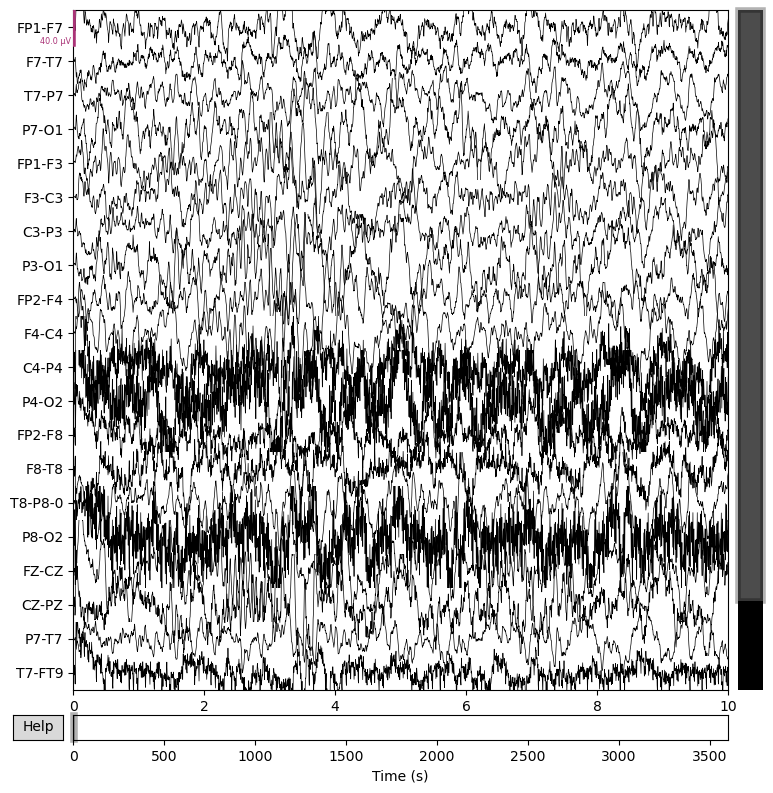

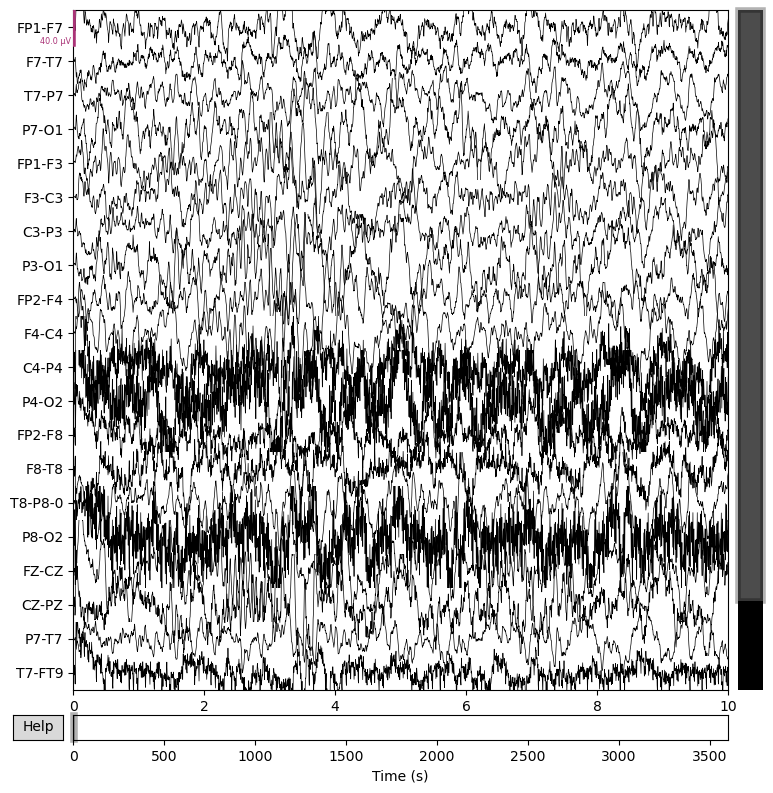

In [26]:
import mne

# Path to EEG data file
eeg_file = '/Users/rukminireddy/Downloads/chb01_18.edf'

# Reading EEG data
raw = mne.io.read_raw_edf(eeg_file, preload=True)

# Print information about the data
print(raw.info)

# Plot the data
raw.plot()

In [41]:
# Define the start and end times of the seizure in seconds
seizurestart = 2996  
seizureend = 3036   

# Extract the seizure data
sdata = raw.copy().crop(tmin=seizurestart, tmax=seizureend)
slabel = 1

# Extract no seizure data
no_seizure_1 = raw.copy().crop(tmin=0, tmax=seizurestart)
no_seizure_2 = raw.copy().crop(tmin=seizureend, tmax=None)
no_seizure_label = 0

In [44]:
import pandas as pd
# Convert to DataFrame
seizure_df = seizure_data.to_data_frame()
no_seizure_df1 = no_seizure_1.to_data_frame()
no_seizure_df2 = no_seizure_2.to_data_frame()

# Add labels
seizure_df['label'] = seizure_label
no_seizure_df1['label'] = no_seizure_label
no_seizure_df2['label'] = no_seizure_label

# Concatenate no seizure parts
no_seizure_df = pd.concat([no_seizure_df1, no_seizure_df2])

# Save to CSV
seizure_df.to_csv('seizure_data.csv', index=False)
no_seizure_df.to_csv('no_seizure_data.csv', index=False)

In [47]:
# Concatenate no_seizure_raw1 to no_seizure_raw2
no_seizure_data = mne.concatenate_raws([no_seizure_1, no_seizure_2])

In [48]:
import numpy as np
from scipy.signal import welch
from scipy.stats import skew, kurtosis
import pandas as pd

def calculate_time_domain_features(data):
    return {
        'mean': np.mean(data, axis=1),
        'std_dev': np.std(data, axis=1),
        'variance': np.var(data, axis=1),
        'skewness': skew(data, axis=1),
        'excess_kurtosis': kurtosis(data, axis=1)
    }

def calculate_frequency_domain_features(data, sampling_frequency):
    psd_list = []
    for channel_data in data:
        freqs, psd = welch(channel_data, sampling_frequency, nperseg=4*sampling_frequency)
        psd_list.append(psd)
    psd_array = np.array(psd_list)

    alpha_band = (8, 12)
    idx_alpha = np.logical_and(freqs >= alpha_band[0], freqs <= alpha_band[1])
    
    alpha_power = np.trapz(psd_array[:, idx_alpha], freqs[idx_alpha], axis=1)
    
    return {'alpha_power': alpha_power}

def calculate_features(raw_data):
    data, times = raw_data[:]
    sampling_frequency = raw_data.info['sfreq']
    time_domain_features = calculate_time_domain_features(data)
    frequency_domain_features = calculate_frequency_domain_features(data, sampling_frequency)
    features = {**time_domain_features, **frequency_domain_features}
    return pd.DataFrame(features)

# Calculate features
seizure_features_dataframe = calculate_features(seizure_data)
no_seizure_features_dataframe = calculate_features(no_seizure_data)

# Add labels for classification
seizure_features_dataframe['label'] = 1  # Seizure
no_seizure_features_dataframe['label'] = 0  # No seizure

# Combine the features into one DataFrame
combined_features_dataframe = pd.concat([seizure_features_dataframe, no_seizure_features_dataframe], ignore_index=True)


In [49]:
from sklearn.model_selection import train_test_split

# Separate features and labels
X = combined_features_df.drop('label', axis=1)
y = combined_features_df['label']

# Split the data into 80% training and 20% remaining
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split the remaining 20% into half validation and half test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

def build_cnn_1d_binary(input_shape):
    model = Sequential()
    
    model.add(Conv1D(32, 2, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.25))

    model.add(Conv1D(64, 2, activation='relu'))
    model.add(MaxPooling1D(1))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    # Adjusted for binary classification
    model.add(Dense(1, activation='sigmoid'))

    return model

input_shape = (6, 1)  # Assuming 6 features per sample

model = build_cnn_1d_binary(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
# Training the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
2/2 [==============================] - 0s 55ms/step - loss: 1.1850 - accuracy: 0.4722 - val_loss: 0.5833 - val_accuracy: 0.4000
Epoch 2/50
2/2 [==============================] - 0s 8ms/step - loss: 2.0491 - accuracy: 0.4444 - val_loss: 0.5053 - val_accuracy: 0.4000
Epoch 3/50
2/2 [==============================] - 0s 9ms/step - loss: 1.9175 - accuracy: 0.4167 - val_loss: 0.4815 - val_accuracy: 0.4000
Epoch 4/50
2/2 [==============================] - 0s 9ms/step - loss: 0.5051 - accuracy: 0.5556 - val_loss: 0.4706 - val_accuracy: 0.4000
Epoch 5/50
2/2 [==============================] - 0s 9ms/step - loss: 0.5254 - accuracy: 0.5000 - val_loss: 0.4634 - val_accuracy: 0.6000
Epoch 6/50
2/2 [==============================] - 0s 10ms/step - loss: 0.5061 - accuracy: 0.5278 - val_loss: 0.4579 - val_accuracy: 0.6000
Epoch 7/50
2/2 [==============================] - 0s 8ms/step - loss: 0.4477 - accuracy: 0.5833 - val_loss: 0.4526 - val_accuracy: 0.6000
Epoch 8/50
2/2 [================

In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the validation set
y_val_pred = model.predict(X_val)
y_val_pred = (y_val_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute the metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")



1/1 [==============================] - 0s 37ms/step
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


In [53]:
y_test_pred = model.predict(X_test)
y_test_pred = (y_test_pred > 0.5).astype(int)  # Convert probabilities to binary predictions


1/1 [==============================] - 0s 11ms/step


In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")


Test Accuracy: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1-Score: 1.0000


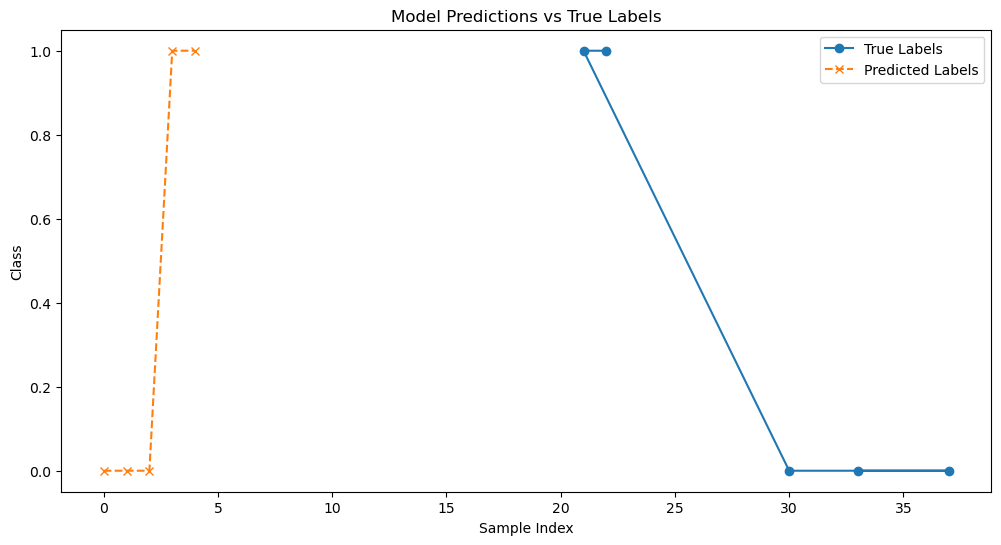

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Labels', marker='o')
plt.plot(y_test_pred, label='Predicted Labels', marker='x', linestyle='--')
plt.title('Model Predictions vs True Labels')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend()
plt.show()


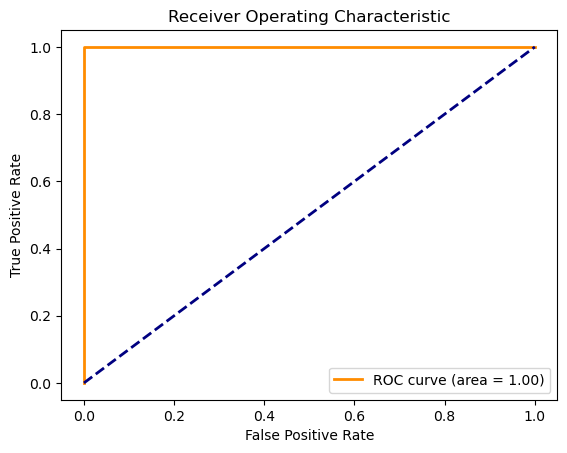

In [56]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


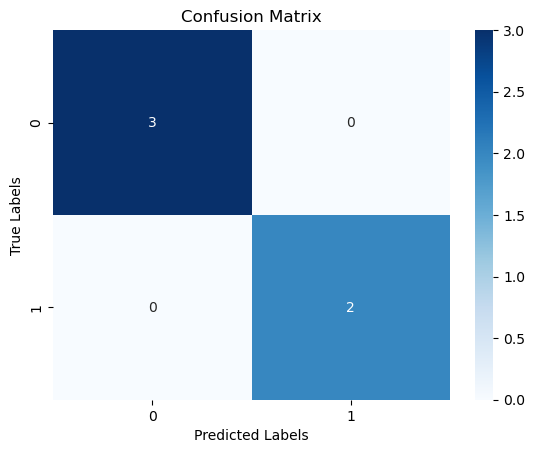

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
